# Predict low, high strategy  EDA

To install conda and binance packages to this notebook uncomment the code below

In [1]:
%%capture
#%conda install -c plotly plotly=5.9.0
#%conda install pip
#%conda install twisted
%pip install plotly==5.9.0
%pip install twisted
%pip install binance-connector==1.13.0
%pip install pandas
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [2]:
#mode="dev"
symbol="BTC-USDT"
mode="yc"
exchange="huobi-hbdm"
#strategy="SimpleKerasStrategy"
strategy="LSTMStrategy"

In [3]:

import os

# Downloading latest pytrade2 data
if mode == "yc":
    os.system("cd ./../deploy/yandex_cloud; ./download_data.sh")
    data_dir=f"../data/yandex-cloud"
else:
    data_dir=f"../data/dev"
    
print(f"Download completed. Local data dir: {data_dir}")

    

receiving incremental file list
LSTMStrategy/LSTMStrategy.db
LSTMStrategy/Xy/2023-06-30_BTC-USDT_X.csv
LSTMStrategy/Xy/2023-06-30_BTC-USDT_data.csv
LSTMStrategy/Xy/2023-06-30_BTC-USDT_y.csv
LSTMStrategy/account/2023-06-30_balance.csv
LSTMStrategy/weights/2023-06-30T13:47:55.488684.data-00000-of-00001
LSTMStrategy/weights/2023-06-30T13:47:55.488684.index
LSTMStrategy/weights/checkpoint

sent 40,564 bytes  received 27,667 bytes  27,292.40 bytes/sec
total size is 13,833,300  speedup is 202.74
LSTMStrategy last opened: 2023-06-30 13:46:39.715000, closed: 2023-06-30 13:44:14.229000
LSTMStrategy2 last opened: 2023-06-25 07:27:09.888000, closed: 2023-06-25 09:23:03.172000
SimpleKerasStrategy last opened: 2023-06-20 17:45:39.118000, closed: 2023-06-20 17:45:47.380000
Current time Пт 30 июн 2023 13:48:28 UTC
Download completed. Local data dir: ../data/yandex-cloud


## Init Huobi or Binance client

In [4]:
import os
import sys
import yaml
from binance.spot import Spot as Client
from huobi.client.account import AccountClient
from huobi.client.algo import AlgoClient
from huobi.client.market import MarketClient
from huobi.client.trade import TradeClient


def load_config_files(cfg_dir:str, paths:{})->{}:
    config={}
    for path in paths:
        fullpath=f"{cfg_dir}/{path}"
        with open(fullpath) as file:
            print("Reading config from "+fullpath)
            config.update(yaml.safe_load(file))
    return config

def load_config_local(strategy:str):
    """
    Load config from cfg folder respecting the order: defaults, app.yaml, environment vars
    """
    print("Reading local config")
    # Defaults
    cfg_dir="./../pytrade2/cfg"
    paths=["app-defaults.yaml", "app.yaml"]
    return load_config_files(cfg_dir, paths)

def load_config_yc(strategy):
    """
    Load config from cfg folder respecting the order: defaults, app.yaml, environment vars
    """
    strategy=strategy.lower()
    print("Reading yc config")
    project_dir="./.."
    cfg_dir=f"{project_dir}/deploy/yandex_cloud/secret/"
    paths=["app.yaml", f"{strategy}.yaml"]

    # Load yc config
    config = load_config_local(strategy)
    config.update(load_config_files(cfg_dir, paths))
    return config

def load_config(strategy):
    """ Read yc or dev config"""
    strategy = strategy.lower()
    return load_config_yc(strategy) if mode == "yc" else load_config_local(strategy)


def create_binance_client(strategy: str, mode: str):
        """ Binance client creation """
        print(mode)
        # Read configs to get keys from there
        strategy=strategy.lower()
        config = load_config(strategy)
        key,secret=config[f"pytrade2.exchange.{exchange}.connector.key"],config[f"pytrade2.exchange.{exchange}.connector.secret"],config[f"pytrade2.exchange.{exchange}.spot.url"]
        return Client(key=key, secret=secret, base_url=url, timeout=10)
#         key,secret,url=config[f"pytrade2.exchange.{exchange}.connector.key"],config[f"pytrade2.exchange.{exchange}.connector.secret"],config[f"pytrade2.exchange.{exchange}.spot.url"]
#         return Client(key=key, secret=secret, base_url=url, timeout=10)

def create_huobi_spot_clients(config, strategy: str, mode: str):
    """ Huobi client creation """
    strategy=strategy.lower()
    key,secret=config[f"pytrade2.exchange.huobi.connector.key"],config[f"pytrade2.exchange.huobi.connector.secret"]
    return  MarketClient(api_key=key, secret_key=secret), \
            AccountClient(api_key=key, secret_key=secret), \
            TradeClient(api_key=key, secret_key=secret)

def create_huobi_hbdm_client(config, strategy):
    """ Huobi derivatives market clients"""
    sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname("."), "./../pytrade2/exch/huobi/hbdm")))
    from HuobiRestClient import HuobiRestClient
    strategy=strategy.lower()
    key,secret=config[f"pytrade2.exchange.huobi.connector.key"],config[f"pytrade2.exchange.huobi.connector.secret"]
    return HuobiRestClient(key, secret)
    

if exchange == "binance":
    binance_client = create_binance_client(strategy, mode)
    quantity_coeff=1
    print("Created Binance client")
elif exchange == "huobi-spot":
    config=load_config(strategy.lower())
    huobi_market_client, huobi_account_client, huobi_trade_client = create_huobi_spot_clients(config, strategy, mode)
    huobi_account_id = config.get("pytrade2.broker.huobi.account.id")
    symbol=symbol.lower()
    quantity_coeff=1
    print("Created huobi spot clients")
elif exchange == "huobi-hbdm":
    config=load_config(strategy.lower())
    symbol=symbol.lower()
    hbdm_client = create_huobi_hbdm_client(config, strategy)
    quantity_coeff=0.001
    print("Created huobi hddm rest client")

#print(hbdm_client.post("/linear-swap-api/v1/swap_balance_valuation", {"valuation_asset": "USDT"}))
    

Reading yc config
Reading local config
Reading config from ./../pytrade2/cfg/app-defaults.yaml
Reading config from ./../pytrade2/cfg/app.yaml
Reading config from ./../deploy/yandex_cloud/secret//app.yaml
Reading config from ./../deploy/yandex_cloud/secret//lstmstrategy.yaml
Created huobi hddm rest client


## Balance plot

In [29]:
import plotly.express as px

def get_balance(strategy: str):
    """ Read balance history from data"""
    
    data_dir=f"../data"
    env_dir="yandex-cloud" if mode == "yc" else "dev"
    account_dir=f"{data_dir}/{env_dir}/{strategy}/account"
    #file_path = sorted([f for f in os.listdir(account_dir) if f.endswith(f"{symbol}_{name}.csv")])[-1]
    files = sorted([f for f in os.listdir(account_dir) if f.endswith(f".csv")])
    df = pd.concat([pd.read_csv(f"{account_dir}/{f}", parse_dates=True, index_col="time") for f in files]).sort_index()
    df["datetime"] = df.index
    return df

balance = get_balance(strategy)
px.line(balance, "datetime", "balance", title=f"{strategy} balance USDT").update_traces(mode='lines+markers').show()



## Account and orders

### Account info

In [5]:
from datetime import datetime

def print_binance_account():
    account=client.account()
    usdt_free=[a["free"] for a in account["balances"] if a["asset"]=="USDT"]
    # update_time=account["update_time"]
    # print(f"account update time:{update_time}")
    print(f"My USDT amount({strategy}): {usdt_free}")

    print(account)
    print(str(pd.to_datetime(account["updateTime"], unit="ms")))
# btc 1.15798200
#usdt 5134.30859706 26.04.2023 14:26
# usdt amount 
# 14.05.2023 9602.27USDT
# 14.05.2023 9613.27USDT
# 15.05.2023 12:11 10851.4496USDT
# 15.05.2023 15:26 USDT 10824.09131356, BTC 0.97100000
# 16.05.2023 19:12 USDT 10824.13392356 BTC 0.97100000
# 16.05.2023 22:09 USDT 10824.13237356, BTC 0.971
# 17.05.2023 0:47  USDT 10824.08461448 BTC 0.971
# 17.05.2023 9:44 USDT 10824.05857448 BTC 0.971
# 17.05.2023 17:22 USDT 10824.00134797 BTC 0.971
# 18.05.2023 08:25:81 USDT 10823.33222738 BTC 0.971
# 18.05.2023 23:09 USDT 10821.81933906 BTC 0.971
# 18.05.2023 07:22 USDT 10821.70723260 BTC 0.971 
# 19.05.2023 15:20 USDT 10820.82563494 locked 27.12356000 BTC 9.970
# 19.95.2023 15:25 USDT 10821.09770494 BTC 0.971

# Set sharp ratio=4
# 19.05.2023 19:36 USDT 10794.27474497 BTC 0.971
# 20.05.2023 15:35 USDT 10821.28357494 BTC 0.971
def print_huobi_spot_account():
    print("Balance:")
    balances = huobi_account_client.get_balance(account_id=huobi_account_id)
    for b in filter(lambda b: b.balance != "0", balances):
        print(vars(b))
def print_huobi_hbdm_account():
    res = hbdm_client.post("/linear-swap-api/v1/swap_balance_valuation", {"valuation_asset": "USDT"})
    
    dt=datetime.fromtimestamp(res["ts"]/1000)
    balances="\n".join([f"{b['valuation_asset']}: {b['balance']}" for b in res["data"]])
    print(f"Balance for {dt}")
    print(balances)
    
if exchange == "binance":
    print_binance_account()
elif exchange == "huobi-spot":
    print_huobi_spot_account()
elif exchange == "huobi-hbdm":
    print_huobi_hbdm_account()


Balance for 2023-06-30 16:48:29.210000
USDT: 32.173674045000000000


### Orders from Exchange

In [6]:
def huobi_order_vars(order):
    """ Convert huobi order to it's attributes """
    order.created_at = pd.to_datetime(order.created_at, unit='ms')
    if order.finished_at: order.finished_at = pd.to_datetime(order.finished_at, unit='ms')
    if order.canceled_at: order.canceled_at = pd.to_datetime(order.canceled_at, unit='ms')
    return vars(order)

In [7]:
import pandas as pd

def get_binance_orders():
    orders = pd.DataFrame(client.get_orders(symbol))
    for timecol in ["time", "updateTime", "workingTime"]:
        orders[timecol] = pd.to_datetime(orders[timecol], unit='ms')
    return orders.set_index("time", drop=False)

def get_huobi_spot_orders():
    orders = huobi_trade_client.get_orders(symbol=symbol, order_state="filled")
    orders = pd.DataFrame([huobi_order_vars(o) for o in orders]).set_index("finished_at", drop=False)
    return orders

def get_huobi_hbdm_orders():
    res = hbdm_client.post("/linear-swap-api/v3/swap_cross_hisorders",
                           {"pair": symbol, "type":1, "trade_type": 0, "status": 0})

    orders=pd.DataFrame(res["data"])
    for timecol in ["create_date", "update_time"]:
        orders[timecol] = pd.to_datetime(orders[timecol], unit='ms')
    orders = orders.set_index("update_time", drop=False).sort_index()        
    return orders


if exchange == "binance":
    orders = get_binance_orders()
elif exchange == "huobi-spot":
    orders = get_huobi_spot_orders()
elif exchange == "huobi-hbdm":
    orders = get_huobi_hbdm_orders()

orders.tail()


,direction,offset,volume,price,profit,pair,query_id,order_id,contract_code,symbol,lever_rate,create_date,order_source,canceled_source,order_price_type,order_type,margin_frozen,trade_volume,trade_turnover,fee,trade_avg_price,status,order_id_str,fee_asset,fee_amount,fee_quote_amount,liquidation_type,margin_asset,margin_mode,margin_account,update_time,is_tpsl,real_profit,trade_partition,reduce_only,contract_type,business_type
update_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-06-30 13:39:11.785,sell,both,1.0,30140.4,0.0000,BTC-USDT,48722565873,1124454110627250177,BTC-USDT,BTC,1,2023-06-30 13:39:11.312,api,,19,1,0.0,1.0,30.1463,-0.012059,30146.3,6,1124454110627250177,USDT,0,0.012059,0,USDT,cross,USDT,2023-06-30 13:39:11.785,1,0.0000,USDT,0,swap,swap
2023-06-30 13:40:38.211,buy,both,1.0,30604.7,-0.1560,BTC-USDT,48722614642,1124454472690450432,BTC-USDT,BTC,1,2023-06-30 13:40:37.637,tpsl,,1,1,0.0,1.0,30.3023,-0.012121,30302.3,6,1124454472690450432,USDT,0,0.012121,0,USDT,cross,USDT,2023-06-30 13:40:38.211,0,-0.1560,USDT,1,swap,swap
2023-06-30 13:42:42.496,sell,both,1.0,30128.0,0.0000,BTC-USDT,48722689615,1124454991487574017,BTC-USDT,BTC,1,2023-06-30 13:42:41.326,api,,19,1,0.0,1.0,30.1445,-0.012058,30144.5,6,1124454991487574017,USDT,0,0.012058,0,USDT,cross,USDT,2023-06-30 13:42:42.496,1,0.0000,USDT,0,swap,swap
2023-06-30 13:44:14.229,buy,both,1.0,30454.0,-0.0918,BTC-USDT,48722735735,1124455376562962432,BTC-USDT,BTC,1,2023-06-30 13:44:13.137,tpsl,,1,1,0.0,1.0,30.2363,-0.012095,30236.3,6,1124455376562962432,USDT,0,0.012095,0,USDT,cross,USDT,2023-06-30 13:44:14.229,0,-0.0918,USDT,1,swap,swap
2023-06-30 13:46:41.138,sell,both,1.0,30024.5,0.0000,BTC-USDT,48722822501,1124455991366623232,BTC-USDT,BTC,1,2023-06-30 13:46:39.715,api,api,19,1,0.0,0.0,0.0000,0.000000,0.0,7,1124455991366623232,USDT,0,0.000000,0,USDT,cross,USDT,2023-06-30 13:46:41.138,1,0.0000,USDT,0,swap,swap


### Opened orders from Exchange

In [8]:
def get_binance_opened_orders():
    orders=pd.DataFrame(client.get_open_orders(symbol))

    for timecol in ["time", "updateTime", "workingTime"]:
        if timecol in orders.columns:
            orders[timecol] = pd.to_datetime(orders[timecol], unit='ms')
    if "time" in orders.columns:
        orders.set_index("time", drop=False, inplace=True)
    return order
    
def get_huobi_spot_opened_orders():
    opened_orders = huobi_trade_client.get_open_orders(symbol=symbol, account_id = huobi_account_id)
    opened_orders = pd.DataFrame([huobi_order_vars(o) for o in opened_orders])
    if not opened_orders.empty: opened_orders = opened.orders.set_index("created_at").round(2)
    return opened_orders

def get_huobi_hbdm_opened_orders():
    res = hbdm_client.post("/linear-swap-api/v1/swap_cross_openorders",
                           {"pair": symbol, "type":1, "trade_type": 0})

    orders=pd.DataFrame(res["data"]["orders"])
    return orders

if exchange == "binance":
    opened_orders = get_binance_opened_orders()
elif exchange == "huobi-spot":
    opened_orders = get_huobi_spot_opened_orders()
elif exchange == "huobi-hbdm":
    opened_orders = get_huobi_hbdm_opened_orders()

print("Opened orders")    
opened_orders.tail()


Opened orders


""


### My trades from Exchange

In [9]:
def get_binance_trades():
    mytrades=pd.DataFrame(client.my_trades(symbol))
    mytrades["time"] = pd.to_datetime(mytrades["time"], unit='ms')
    mytrades.tail()

def get_huobi_hbdm_trades():
    res = hbdm_client.post("/linear-swap-api/v3/swap_cross_hisorders",
                           {"pair": symbol, "type":1, "trade_type": 0, "status": 6})

    orders=pd.DataFrame(res["data"])
    for timecol in ["create_date", "update_time"]:
        orders[timecol] = pd.to_datetime(orders[timecol], unit='ms')
    orders = orders.set_index("update_time", drop=False).sort_index()        
    return orders

if exchange == "binance":
    exch_trades = get_binance_trades().tail()
elif exchange == "huobi-hbdm":
    exch_trades = get_huobi_hbdm_trades()
    
exch_trades.tail()
    

,direction,offset,volume,price,profit,pair,query_id,order_id,contract_code,symbol,lever_rate,create_date,order_source,canceled_source,order_price_type,order_type,margin_frozen,trade_volume,trade_turnover,fee,trade_avg_price,status,order_id_str,fee_asset,fee_amount,fee_quote_amount,liquidation_type,margin_asset,margin_mode,margin_account,update_time,is_tpsl,real_profit,trade_partition,reduce_only,contract_type,business_type
update_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-06-30 13:37:33.362,buy,both,1.0,30444.5,0.2741,BTC-USDT,48722508457,1124453696077316096,BTC-USDT,BTC,1,2023-06-30 13:37:32.478,tpsl,,7,1,0.0,1.0,30.4374,-0.012175,30437.4,6,1124453696077316096,USDT,0,0.012175,0,USDT,cross,USDT,2023-06-30 13:37:33.362,0,0.2741,USDT,1,swap,swap
2023-06-30 13:39:11.785,sell,both,1.0,30140.4,0.0000,BTC-USDT,48722565873,1124454110627250177,BTC-USDT,BTC,1,2023-06-30 13:39:11.312,api,,19,1,0.0,1.0,30.1463,-0.012059,30146.3,6,1124454110627250177,USDT,0,0.012059,0,USDT,cross,USDT,2023-06-30 13:39:11.785,1,0.0000,USDT,0,swap,swap
2023-06-30 13:40:38.211,buy,both,1.0,30604.7,-0.1560,BTC-USDT,48722614642,1124454472690450432,BTC-USDT,BTC,1,2023-06-30 13:40:37.637,tpsl,,1,1,0.0,1.0,30.3023,-0.012121,30302.3,6,1124454472690450432,USDT,0,0.012121,0,USDT,cross,USDT,2023-06-30 13:40:38.211,0,-0.1560,USDT,1,swap,swap
2023-06-30 13:42:42.496,sell,both,1.0,30128.0,0.0000,BTC-USDT,48722689615,1124454991487574017,BTC-USDT,BTC,1,2023-06-30 13:42:41.326,api,,19,1,0.0,1.0,30.1445,-0.012058,30144.5,6,1124454991487574017,USDT,0,0.012058,0,USDT,cross,USDT,2023-06-30 13:42:42.496,1,0.0000,USDT,0,swap,swap
2023-06-30 13:44:14.229,buy,both,1.0,30454.0,-0.0918,BTC-USDT,48722735735,1124455376562962432,BTC-USDT,BTC,1,2023-06-30 13:44:13.137,tpsl,,1,1,0.0,1.0,30.2363,-0.012095,30236.3,6,1124455376562962432,USDT,0,0.012095,0,USDT,cross,USDT,2023-06-30 13:44:14.229,0,-0.0918,USDT,1,swap,swap


### Trades from bot database

In [10]:
import pandas as pd
import numpy as np

def get_trades(data_dir: str, strategy: str, mode: str):
    import sqlite3
    db_path=f"{data_dir}/{strategy}/{strategy}.db"
    fee=0.00012
    print(f"Get trades from {db_path}")

    with sqlite3.connect(db_path) as conn:
        trades=pd.read_sql_query("SELECT * FROM trade ORDER BY open_time",conn,
                                 parse_dates=["open_time", "close_time"])#.set_index("open_time", drop=False)
    trades["profit"] = np.where(trades["side"] == "BUY", 
                                (trades["close_price"]-trades["open_price"])*trades["quantity"]*quantity_coeff,
                                (trades["open_price"]-trades["close_price"])*trades["quantity"]*quantity_coeff,
                               )
    trades["profit"] = trades["profit"] - fee*(trades["open_price"] + trades["close_price"])*trades["quantity"]*quantity_coeff
    trades["cum_profit"] = trades["profit"].cumsum()
    
    return trades

trades=get_trades(data_dir, strategy, mode)
trades.tail()

Get trades from ../data/yandex-cloud/LSTMStrategy/LSTMStrategy.db


,id,ticker,side,open_time,open_price,open_order_id,stop_loss_price,take_profit_price,stop_loss_order_id,trailing_delta,quantity,close_time,close_price,close_order_id,status,profit,cum_profit
20,21,BTC-USDT,SELL,2023-06-30 12:18:20.970,30971.4,1124433766818045952,31343.6,0.0,"1124433766834823169,1124433766834823168",None,1.0,2023-06-30 12:27:36.559,31043.7,1124436091325136896,closed,-0.079742,0.077366
21,22,BTC-USDT,SELL,2023-06-30 13:36:12.218,30711.5,1124453359450341376,31190.3,0.0,"1124453359475507201,1124453359475507200",None,1.0,2023-06-30 13:37:33.362,30437.4,1124453696077316096,closed,0.266762,0.344128
22,23,BTC-USDT,SELL,2023-06-30 13:39:11.312,30146.3,1124454110627250177,30604.7,0.0,"1124454110648221697,1124454110648221696",None,1.0,2023-06-30 13:40:38.211,30302.3,1124454472690450432,closed,-0.163254,0.180874
23,24,BTC-USDT,SELL,2023-06-30 13:42:41.326,30144.5,1124454991487574017,30454.0,0.0,"1124454991508545539,1124454991508545538",None,1.0,2023-06-30 13:44:14.229,30236.3,1124455376562962432,closed,-0.099046,0.081829
24,25,BTC-USDT,SELL,2023-06-30 13:46:39.715,NaN,1124455991366623232,30443.9,0.0,"1124455991383400449,1124455991383400448",None,1.0,NaT,NaN,None,opening,NaN,NaN


In [11]:
print(f"Total profit: {trades['profit'].sum()}")


Total profit: 0.08182865200000072


### Opened trades from trade bot database

In [12]:
trades[trades.close_time.isna()].tail()

,id,ticker,side,open_time,open_price,open_order_id,stop_loss_price,take_profit_price,stop_loss_order_id,trailing_delta,quantity,close_time,close_price,close_order_id,status,profit,cum_profit
24,25,BTC-USDT,SELL,2023-06-30 13:46:39.715,NaN,1124455991366623232,30443.9,0.0,"1124455991383400449,1124455991383400448",None,1.0,NaT,NaN,None,opening,NaN,NaN


## Profit

In [13]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set_theme()
#paper, notebook, talk, poster

import plotly.graph_objs as go
import plotly.io as pio
from plotly.subplots import make_subplots
pio.renderers.default = "plotly_mimetype+notebook"
import plotly.graph_objects as go

    
plot_figsize=(10,5)


def plot_profits_plotly(trades):
    """ Plot profit charts using plotly"""
    px.line(trades, x="open_time", y="profit", title=f"{strategy} profit").update_traces(mode='lines+markers').show()
    px.line(trades, x="open_time", y="cum_profit", title=f"{strategy} cumulative profit").update_traces(mode='lines+markers').show()

def plot_profits_sns(trades):
    """ Plot profit charts using sns"""
    plt.figure(figsize=plot_figsize)
    sns.set_style("darkgrid")
    sns.lineplot(data=trades, x="open_time", y="profit").set_title(f"{strategy} profit")
    plt.show()

    #sns.set_palette("deep")
    sns.set_style("whitegrid")
    plt.figure(figsize=plot_figsize)
    sns.lineplot(data=trades, x="open_time", y="cum_profit").set_title( f"{strategy} cumulative profit")
    plt.show()
    
    # Cumulative profit w/o outliers
    profit=trades[["open_time","profit"]].set_index("open_time")
    q_low = profit["profit"].quantile(0.1)
    q_hi  = profit["profit"].quantile(0.9)
    profit_filtered = profit[(profit["profit"] < q_hi) & (profit["profit"] > q_low)]
    cumsum_filtered = profit_filtered.cumsum()
    plt.figure(figsize=plot_figsize)
    sns.set_style("darkgrid")
    sns.lineplot(data=cumsum_filtered).set_title(f"{strategy} profit w/o outliers")
    plt.show()

def plot_profits_plt(trades):
    """ Plot profits using matplotlib """
    plt.figure(figsize=(10,5))
    sns.set_style("whitegrid")
    plt.plot("open_time", "profit", data=trades)
    plt.title(f"{strategy} profit")
    plt.show()
    
    sns.set_style("darkgrid")
    plt.figure(figsize=(10,5))
    plt.plot("open_time", "cum_profit", data=trades)
    plt.title(f"{strategy} cumulative profit")
    plt.show()

plot_profits_plotly(trades)
#plot_profits_sns(trades[:-1:])
#plot_profits_plt(trades)


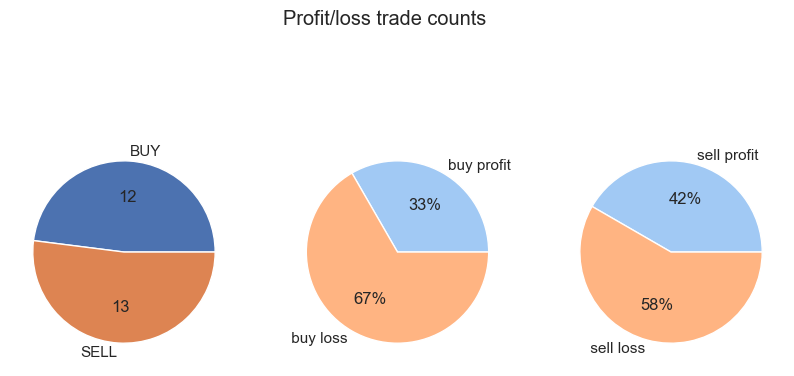

In [14]:
from matplotlib import pyplot as plt
import seaborn as sns


def plot_trade_counts(trades):
    buy_sell_counts = trades["side"].value_counts()
    total=len(trades)
    colors = sns.color_palette('pastel')[0:5]
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(plot_figsize)
    fig.suptitle('Profit/loss trade counts')
    # Buy/sell counts
    ax1.pie([len(trades[trades["side"]=="BUY"]),len(trades[trades["side"]=="SELL"])], 
            labels=["BUY","SELL"], \
            autopct=lambda p: '{:.0f}'.format(p * total / 100))
    # Buy profit/loss counts
    ax2.pie([len(trades[(trades["side"]=="BUY") &  (trades["profit"]>0)].index),\
            len(trades[(trades["side"]=="BUY") &  (trades["profit"]<0)].index) \
            ],
            labels=["buy profit", " buy loss"], autopct="%.0f%%", colors=colors)
    # Sell profit/loss counts
    ax3.pie([len(trades[(trades["side"]=="SELL") &  (trades["profit"]>0)].index),\
            len(trades[(trades["side"]=="SELL") &  (trades["profit"]<0)].index) \
            ],
            labels=["sell profit", " sell loss"], autopct="%.0f%%", colors=colors)

    
plot_trade_counts(trades)



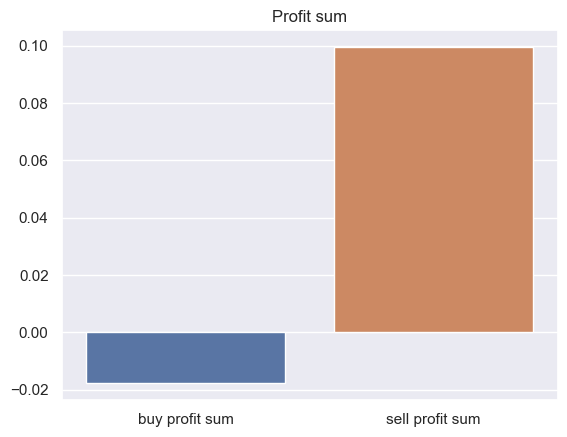

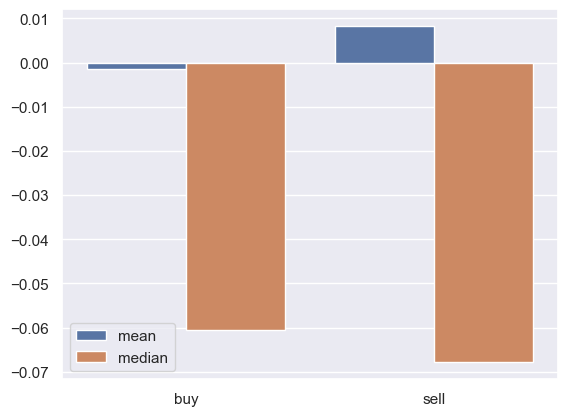

In [15]:
import plotly.express as px

def plot_profit_stat_plotly(trades):
    """ Profit statistics: summary, average """
    buy_profit = trades.loc[trades["side"]=="BUY","profit"]
    sell_profit = trades.loc[trades["side"]=="SELL","profit"]
    px.bar(x=["buy_profit_sum", "sell_profit_sum"], y=[buy_profit.sum(), sell_profit.sum()], title="Buy/sell profit sum").show()
    px.bar(x=["buy_profit_mean", "sell_profit_mean"], y=[buy_profit.mean(), sell_profit.mean()], title="Buy/sell mean profit").show()

def plot_profit_stat_sns(trades):
    """ Profit statistics: summary, average """
    buy_profit = trades.loc[trades["side"]=="BUY","profit"]
    sell_profit = trades.loc[trades["side"]=="SELL","profit"]
    buy_profit_mean, sell_profit_mean = buy_profit.mean(), sell_profit.mean()
    buy_profit_mdn, sell_profit_mdn = buy_profit.median(), sell_profit.median()
    
    sns.barplot(x=["buy profit sum", "sell profit sum"], y = [buy_profit.sum(), sell_profit.sum()])
    plt.title("Profit sum")
    plt.show()
    #sns.set_style("whitegrid")
    
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     fig.set_size_inches(plot_figsize)
#     fig.align_ylabels(ax2)    

    data={"val": [buy_profit.mean(), sell_profit.mean(), buy_profit.median(), sell_profit.median()],
          "type": ["buy", "sell", "buy", "sell"],
          "agg": ["mean", "mean", "median", "median"]
         }
    sns.barplot(data=data, x="type", y="val", hue="agg")
    #sns.barplot(x=["buy profit median", "sell profit median"], y = [buy_profit.median(), sell_profit.median()],ax=ax2)
    #fig.show()
    
#     px.bar(x=["buy_profit_sum", "sell_profit_sum"], y=[buy_profit.sum(), sell_profit.sum()], title="Buy/sell profit sum").show()
#     px.bar(x=["buy_profit_mean", "sell_profit_mean"], y=[buy_profit.mean(), sell_profit.mean()], title="Buy/sell mean profit").show()
    
plot_profit_stat_sns(trades)

## Trades on candlestick chart

In [16]:
from datetime import datetime
from huobi.model.market.candlestick import Candlestick

def get_last_candles_binance():
    candle_columns = ["open_time", "open", "high", "low", "close", "vol", "close_time", "quote_asset_volume",
                      "number_of_trades", " taker_buy_base_asset_volume", "taker_buy_quote_asset_volume",
                      "ignore"]    
    end_date=trades.open_time.max() if not trades.empty else datetime.utcnow()
    
    #end_time_millis=end_date.value//1000000
    cnt=24*60 # Number of last candles to read
    raw_candles = client.klines(symbol=symbol,
                                    interval="1m",
                                    #limit=10,
                                    limit=cnt,
                                    #endTime=end_time_millis
                               )
    df = pd.DataFrame(raw_candles, columns=candle_columns)
    df["open_time"] = pd.to_datetime(df["open_time"], unit='ms')
    df["close_time"] = pd.to_datetime(df["close_time"], unit='ms')
    df.set_index("open_time", drop=False, inplace=True)
        # Convert strings to float prices
    df[["open", "high", "low", "close"]] = df[["open", "high", "low", "close"]].astype(float)
    return df

def clean_candles_binance(df):
    """ Remove outliers """
    q_low = df["low"].diff().quantile(0.1)
    q_high  = df["high"].diff().quantile(0.9)
    df=df[df["high"].diff()< q_high]
    df=df[df["low"].diff() > q_low ]
    return df

def get_last_candles_huobi():
        """ Read candles from Huobi """
        # Get candles
        interval="1m"
        size=2000
        candles = huobi_market_client.get_candlestick(symbol=symbol, period="1min", size=size)
        candles = [vars(c) for c in candles]

        # Huobi candles don't have time, so generate times for last candles
        deltatime = pd.Timedelta(interval+"in")
        times = [datetime.utcnow() - deltatime * i for i in range(len(candles))]
        candles = pd.DataFrame(candles, index=times)
        candles["close_time"] = candles.index
        candles["open_time"] = candles["close_time"] - deltatime

        return candles.sort_index()

if exchange == "binance":
    candles = get_last_candles_binance()
    candles = clean_candles_binance(candles)
elif exchange == "huobi":
    candles = get_last_candles_huobi()

candles.tail()

NameError: name 'candles' is not defined

In [ ]:
# Install a conda package in the current Jupyter kernel
#%conda install -c plotly plotly=5.9.0
# Draw candlechart
import plotly as py
from plotly import graph_objects as go
import pandas as pd
import numpy as np
import datetime

def get_chart_figure(candles: pd.DataFrame, trades: pd.DataFrame)->pd.DataFrame:
    """
    Form plotly candlestick chart with buy/sell marks on it
    """
    
    df=candles.copy()
    #df=clean_candles(df)
    fig = go.Figure(data=[ \
                        go.Candlestick(\
                            x=df.index,\
                            open=df['open'],\
                            high=df['high'],\
                            low=df['low'],\
                            close=df['close'])
                         ])

    # Customize ay to distribute captions by y so they do not overlap by x
    ay,aymax,aystep=0,50,10
    #start_time=df.open_time.min()
    # Annotate buy, sell on the chart
    for i,trade in trades[(~trades["open_time"].isna()) & (trades["open_time"] > df.open_time.min())].iterrows():
        ay=(ay+aystep)%aymax
        color='green' if trade['side']=="BUY" else 'red'

        # Draw open order
        open_text='buy' if trade['side']=="BUY"  else 'sell'
        open_hover=f"{trade['open_time']} {open_text} at {str(trade['open_price'])}, sl={trade['stop_loss_price']}, tp={trade['take_profit_price']}"
        fig.add_annotation(x=trade['open_time'], \
                           y=trade['open_price'],\
                           text=open_text,\
                           hovertext=open_hover,\
                           showarrow=True,arrowhead=5,arrowcolor=color,ay=-ay,arrowwidth=2,
                           font={'color':color}
                          )
    for i,trade in trades[(~trades.close_time.isna()) & (trades.close_time > df.close_time.min())].iterrows():
        color='green' if trade['side']=="BUY" else 'red'

        # Draw close order
        #profit = trade["close_price"]-trade["open_price"] if trade["close_price"] else None
        status= f", profit: {round(trade.profit, 10)}" if trade.profit else ""
        close_text=f"close {trade['side'].lower()}"
        close_hover=f"{trade['close_time']} {close_text} at {str(trade['close_price'])}{status}"
        fig.add_annotation(x=trade['close_time'], \
                           y=trade['close_price'],\
                           text=close_text,\
                           hovertext=close_hover,\
                           showarrow=True,arrowhead=5,arrowcolor=color,ay=-ay,arrowwidth=2,\
                           font={'color':color}
                          )
    return fig

get_chart_figure(candles, trades).show()



## Predicted and actual low/high

In [ ]:
import os
import glob
import pandas as pd
from datetime import timedelta,date
import matplotlib.pyplot as plt
import plotly.express as px

def read_last_data(data_dir, strategy):
    """ Read days from start to end from local predictions history"""
    
    def read_last(symbol: str, name: str, n: int):
        xy_dir=f"{data_dir}/{strategy}/Xy"
        file_path = sorted([f for f in os.listdir(xy_dir) if f.endswith(f"{symbol}_{name}.csv")])[-1]
        file_path = f"{xy_dir}/{file_path}"
        print(f"Read from {file_path}")
        return pd.read_csv(file_path, parse_dates=True, index_col="datetime").tail(n)
    n=1000
    data=read_last("BTCUSDT", "data", n)
    X=read_last("BTCUSDT", "X", n)
    y=read_last("BTCUSDT", "y", n)
    data=pd.merge(data[["symbol"]],y, left_index=True, right_index=True) 
    #y=pd.concat([data,y])
    return data,X,y


# Read candles for last 3 days
data,x,y = read_last_data(data_dir, strategy)
data.tail(100)

In [ ]:

def get_predictions(data):
    """ 
    Merge predicted and real prices for analysis 
    """
    
    # Prediction window is constant, get it from last row
    predicted=data[["bid","ask","bid_min_fut", "bid_max_fut", "ask_min_fut", "ask_max_fut"]]
    predicted.columns=[c.replace("_fut", "_predicted") for c in predicted.columns]
    predict_window=data["predict_window"].tail(1).values[0]
    real_min=data[["bid", "ask"]].rolling(predict_window).min().rename(columns={"bid":"bid_min_real", "ask":"ask_min_real"})
    real_max=data[["bid", "ask"]].rolling(predict_window).max().rename(columns={"bid":"bid_max_real", "ask":"ask_max_real"})
    real=pd.concat([real_min, real_max], axis=1)
    real["prediction_datetime"]=real.index.to_series()-pd.to_timedelta(predict_window)
    merged=pd.merge_asof(real, predicted, left_on="prediction_datetime", right_index=True, direction='forward')
    return merged[["bid", "ask", "bid_min_real", "bid_min_predicted", "bid_max_real", "bid_max_predicted", \
                   "ask_min_real", "ask_min_predicted", "ask_max_real", "ask_max_predicted"]]


# predicted=data[["bid","ask","bid_min_fut", "bid_max_fut", "ask_min_fut", "ask_max_fut"]]
# predicted.columns=[c.replace("_fut", "_predicted") for c in predicted.columns]
# predict_window=data["predict_window"].tail(1).values[0]
# real_min=data[["bid", "ask"]].rolling(predict_window).min().rename(columns={"bid":"bid_min_real", "ask":"ask_min_real"})
# real_max=data[["bid", "ask"]].rolling(predict_window).max().rename(columns={"bid":"bid_max_real", "ask":"ask_max_real"})
# real=pd.concat([real_min, real_max], axis=1)
# real["prediction_datetime"]=real.index.to_series()-pd.to_timedelta(predict_window)

# pd.merge_asof(real, predicted, left_on="prediction_datetime", right_index=True, direction='backward')


predictions = get_predictions(data)
predictions.info()
print(f"predict_window={data['predict_window'].values[-1]}")

## Prediction errors

In [ ]:
def plot_prediction_err(predictions):
    df = pd.DataFrame(index=predictions.index)
    for bidask in ["bid", "ask"]:
        for maxmin in ["max", "min"]:
            prefix = f"{bidask}_{maxmin}"
            df[f"{prefix}_error"] = predictions[f"{prefix}_predicted"] - predictions[f"{prefix}_real"]
    
    px.line(df, title="Errors", markers=True).show()
    px.line(df.sum(axis=1).abs().rename("error sum"), title="Error summary", markers=True).show()
    
plot_prediction_err(predictions)

In [ ]:
import pandas as pd

def get_profits(predictions: pd.DataFrame)->pd.DataFrame:
    """
    Buy, sell profit, real and predicted, for each time moment
    """
    
    profits = pd.DataFrame()
    # Profit/loss ratio to consider buy or sell
    min_ratio=1

    # Calculate possible profits for buy or sell
    profits["buy_profit_predicted"] = predictions["bid_max_predicted"] - predictions["ask"]
    profits["buy_loss_predicted"] = predictions["ask"]-predictions["bid_min_predicted"]
    profits['buy_ratio_predicted'] = np.where(profits['buy_loss_predicted'] > 0, profits['buy_profit_predicted'] / profits['buy_loss_predicted'],float('inf'))

    profits["buy_profit_real"] = predictions["bid_max_real"] - predictions["ask"]
    profits["buy_loss_real"] = predictions["ask"]-predictions["bid_min_real"]
    profits['buy_ratio_real'] = np.where(profits['buy_loss_real'] > 0, profits['buy_profit_real'] / profits['buy_loss_real'],float('inf'))


    profits["sell_profit_predicted"] = predictions["bid"] - predictions["ask_min_predicted"]
    profits["sell_loss_predicted"] = predictions["ask_max_predicted"] - predictions["bid"]
    profits['sell_ratio_predicted'] = np.where(profits['sell_loss_predicted'] > 0, profits['sell_profit_predicted'] / profits['sell_loss_predicted'],float('inf'))

    profits["sell_profit_real"] = predictions["bid"] - predictions["ask_min_real"]
    profits["sell_loss_real"] = predictions["ask_max_real"] - predictions["bid"]
    profits['sell_ratio_real'] = np.where(profits['sell_loss_real'] > 0, profits['sell_profit_real'] / profits['sell_loss_real'],float('inf'))


    profits["signal"] = np.where(profits['buy_ratio_predicted'] >= min_ratio, 1,
                                 np.where(profits["sell_ratio_predicted"]>=min_ratio, -1,0 ))

    # Calculate real profit or loss
    profits["profit_real"] = np.where(
        # If buy                             
        profits["signal"]==1,
        np.where(
            # Real movement down was inside what we predicted
            (predictions["bid_min_real"] < predictions["bid_min_predicted"]) 
            & (predictions["bid_max_real"] <= predictions["bid_max_predicted"]),
            # Take the profit
            profits["buy_profit_predicted"],
            # Or fix the loss
            -profits["buy_loss_predicted"]
        ),
        # If Sell                     
        np.where(profits["signal"] == -1,
            np.where(
                # Real movement down was inside what we predicted
                (predictions["ask_max_real"] > predictions["ask_max_predicted"]) 
                & (predictions["ask_min_real"] >= predictions["ask_max_predicted"]),
                # Take the profit
                profits["sell_profit_predicted"],
                # Or fix the loss
                -profits["sell_loss_predicted"]
            ),
            # If neither buy nor sell, return NaN
            np.nan
        )
    )

    # Fill in predicted profit
    profits["profit_predicted"]=np.where(profits["signal"] == 1, 
                                         # If buy
                                         profits["buy_profit_predicted"], 
                                        np.where(profits["signal"]==-1,
                                                # If sell
                                                profits["sell_profit_predicted"],
                                                # If neither buy not sell
                                                 np.nan))
    return profits

profits = get_profits(predictions)
pd.set_option('display.max_rows', 1000)
pd.concat([predictions,profits],axis=1).tail()
#profits.dropna().tail(100)




In [ ]:
print(f"Total prediction profit sum: {profits['profit_real'].sum()}")



In [ ]:
#px.line(profits[["profit_predicted", "profit_real"]], markers=True)
px.line(profits["profit_predicted"]-profits["profit_real"])

## Sharp ratio

In [ ]:
sharp_ratio_df=profits[["buy_ratio_predicted", "buy_ratio_real", "sell_ratio_predicted", "sell_ratio_real"]]
sharp_ratio_df.tail()


In [ ]:
px.line(sharp_ratio_df[["buy_ratio_predicted", "buy_ratio_real"]], title="Buy sharp ratio")

In [ ]:
px.line(sharp_ratio_df[["sell_ratio_predicted", "sell_ratio_real"]], title="Sell sharp ratio")

## Signal analysis

In [ ]:
y.tail()
y.plot(y= "open_signal", title="open signal")
plt.show()